In [1]:
import pandas as pd
import yfinance as yf
start = '2021-01-01'
end = '2023-12-31'
symbol = 'AAPL' # "005930.KS"
df = yf.download(symbol, start, end)
df = df.rename(columns={'Adj Close': 'Adj_Close'})
df['ds'] = pd.to_datetime(df.index, format = '%Y-%m-%d') # 굳이 넣어야하나 고민중
df['y'] = df['Close'] # 마찬가지로 굳이 넣어야하나 고민중
df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj_Close,Volume,ds,y
Date,,,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.002090,143301900,2021-01-04,129.410004
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.572296,97664900,2021-01-05,131.009995
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.244385,155088000,2021-01-06,126.599998


In [2]:
import numpy as np
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

,ds,y
Date,,
2021-01-04,2021-01-04,129.410004
2021-01-05,2021-01-05,131.009995
2021-01-06,2021-01-06,126.599998
2021-01-07,2021-01-07,130.919998
2021-01-08,2021-01-08,132.050003
...,...,...
2023-12-22,2023-12-22,193.600006
2023-12-26,2023-12-26,193.050003
2023-12-27,2023-12-27,193.149994


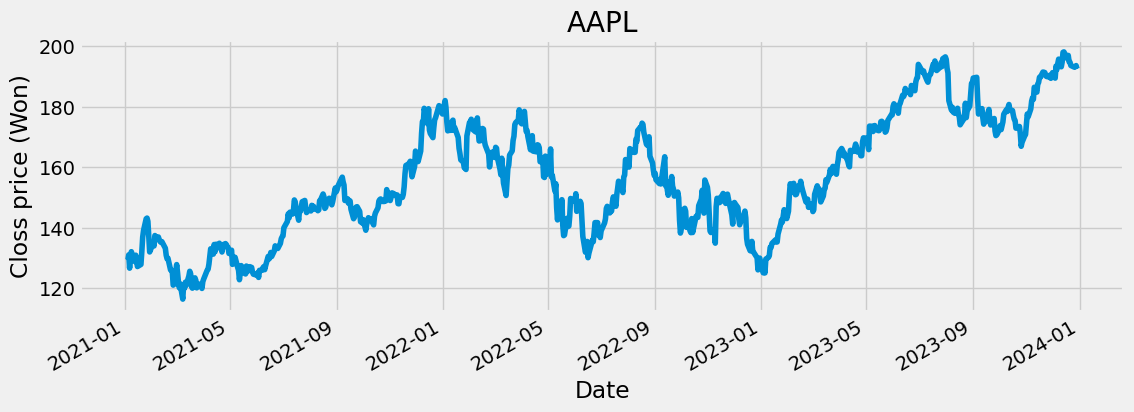

In [3]:
df_input = df[['ds','y']]
display(df_input)
ax = df_input['y'].plot(title = symbol, figsize =(12,4))
ax.set_ylabel('Closs price (Won)')
plt.show()

In [4]:
model_prophet = Prophet(changepoint_prior_scale = 0.15, daily_seasonality = True)
model_prophet.fit(df_input)

08:24:40 - cmdstanpy - INFO - Chain [1] start processing
08:24:41 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
fcast_time = 40 #365 # 365일 예측
freq_option = 'D'
future = model_prophet.make_future_dataframe(periods = fcast_time, freq = freq_option)
future.tail(10)

,ds
783,2024-01-29
784,2024-01-30
785,2024-01-31
786,2024-02-01
787,2024-02-02
788,2024-02-03
789,2024-02-04
790,2024-02-05
791,2024-02-06
792,2024-02-07


In [6]:
from workalendar.usa import UnitedStates
# AAPL의 경우 미국 거래소에서 거래가 이루어지니 미국 공휴일 정보 가져와서 리스트로 만드는 과정
# cal = workalendar.usa.UnitedStates()
cal = UnitedStates()
holiday_dates = []

for year in range(2021, 2025):  # 2021년부터 2024년까지
    holiday_dates.extend([date for date, _ in cal.holidays(year)])

In [7]:
future = future[future['ds'].dt.dayofweek < 5] # 주말 제외 작업
future = future[~future['ds'].isin(holiday_dates)] # 공휴일 제외 작업

In [8]:
df_forecast = model_prophet.predict(future)
df_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
767,2024-02-01,197.872903,191.839286,204.539766
768,2024-02-02,198.395566,192.170214,205.839407
769,2024-02-05,199.318007,192.755009,206.534947
770,2024-02-06,199.476582,192.169290,206.681015
771,2024-02-07,199.589177,192.856683,206.755492


In [9]:
start_r = '2024-01-01'
end_r = '2024-01-31'
ticker_r = 'AAPL'

df_recent = yf.download(ticker_r, start=start_r, end=end_r)
df_recent['ds'] = pd.to_datetime(df_recent.index, format = '%Y-%m-%d')
df_recent['y'] = df_recent['Close']
display(df_recent.head(3))

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ds,y
Date,,,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.403412,82488700,2024-01-02,185.639999
2024-01-03,184.220001,185.880005,183.429993,184.250000,184.015198,58414500,2024-01-03,184.250000
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.678177,71983600,2024-01-04,181.910004


In [10]:
df_forecast_compare = df_forecast.set_index('ds')
df_forecast_compare.head(3)

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2021-01-04,125.837293,127.688979,138.752152,125.837293,125.837293,7.130274,7.130274,7.130274,2.360639,2.360639,...,0.160907,0.160907,0.160907,4.608728,4.608728,4.608728,0.0,0.0,0.0,132.967567
2021-01-05,125.788028,127.298748,138.161019,125.788028,125.788028,6.900233,6.900233,6.900233,2.360639,2.360639,...,0.143280,0.143280,0.143280,4.396314,4.396314,4.396314,0.0,0.0,0.0,132.688260
2021-01-06,125.738762,126.579255,138.151151,125.738762,125.738762,6.693765,6.693765,6.693765,2.360639,2.360639,...,0.150670,0.150670,0.150670,4.182456,4.182456,4.182456,0.0,0.0,0.0,132.432527


In [11]:
test_data = df_recent['y']
fc = df_forecast_compare[df_forecast_compare.index>='2024-01-01'].iloc[:len(test_data)]['yhat']

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

mse = mean_squared_error(test_data, fc)
print('MSE: ', mse)
mae = mean_absolute_error(test_data, fc)
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: ', rmse)
mape = mean_absolute_percentage_error(test_data, fc)
print('MAPE: ' , '{:.2f}%'.format(mape*100))
r2score = r2_score(test_data,fc)
print('r2 score: ', r2score)

MSE:  50.66070232779758
MAE:  6.0082444053746995
RMSE:  7.117633197053468
MAPE:  3.24%
r2 score:  -1.5912036328322543


In [12]:
# ax = df_input['y'].plot(title = symbol, figsize =(12,4))
# ax.set_ylabel('Closs price (Won)')
# plt.show()

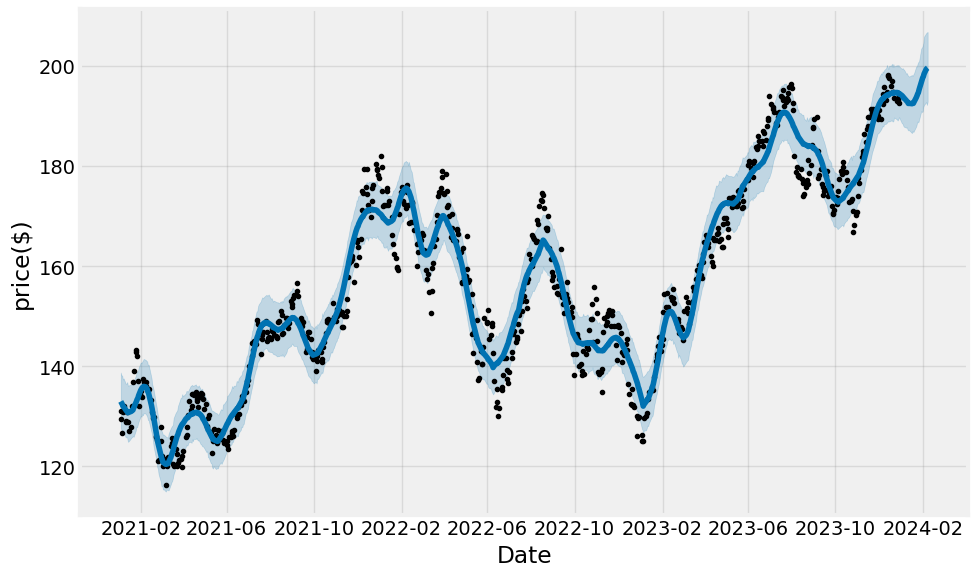

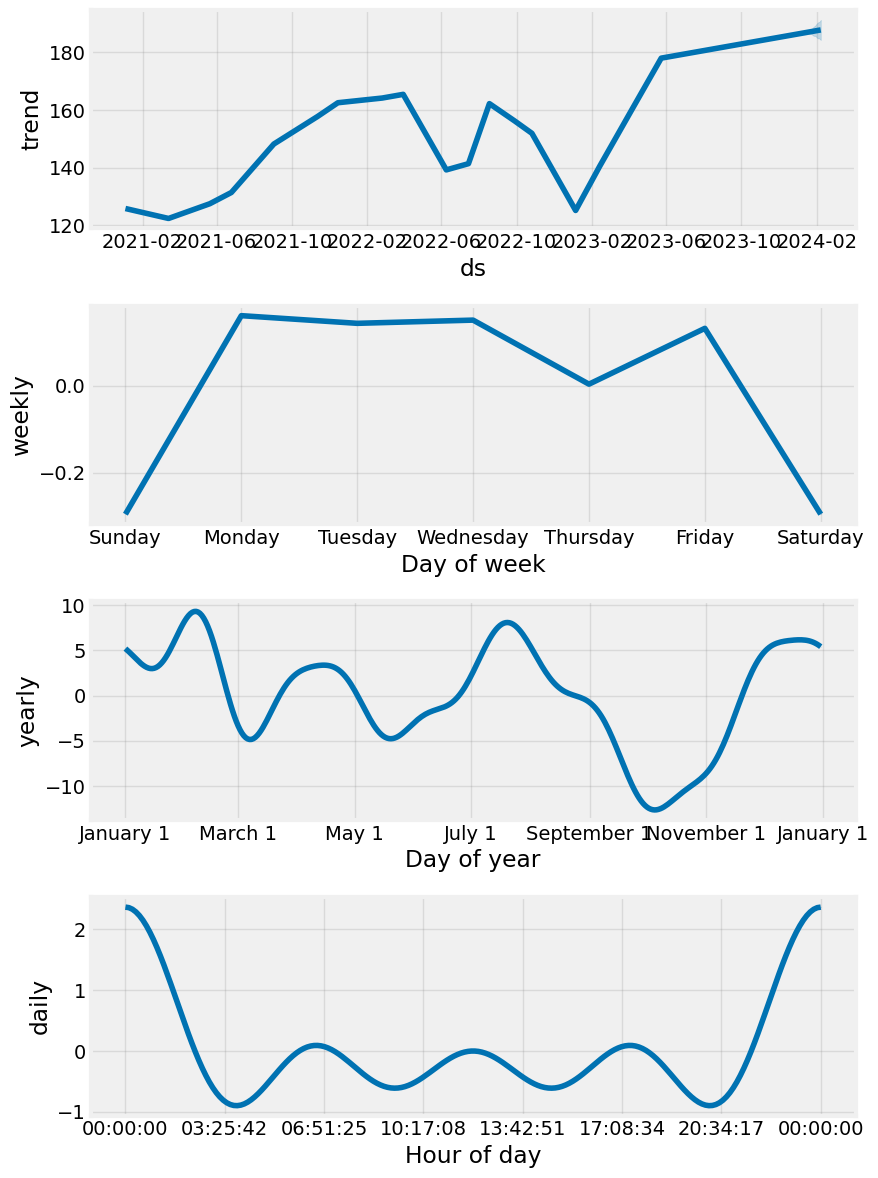

In [13]:
model_prophet.plot(df_forecast, xlabel = 'Date',ylabel ='price($)')
model_prophet.plot_components(df_forecast);

In [14]:
model_prophet2 = Prophet(changepoint_prior_scale = 0.3, daily_seasonality = True)
model_prophet2.fit(df_input)
# fcast_time = 365 # 365일 예측
# freq_option = 'D'
future2 = model_prophet2.make_future_dataframe(periods = fcast_time, freq = freq_option)
future2 = future2[future2['ds'].dt.dayofweek < 5] # 주말 제외 작업
future2 = future2[~future2['ds'].isin(holiday_dates)] # 공휴일 제외 작업
df_forecast2 = model_prophet2.predict(future2)
df_forecast2[['ds','yhat','yhat_lower','yhat_upper']].tail()

08:24:46 - cmdstanpy - INFO - Chain [1] start processing
08:24:46 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
767,2024-02-01,196.348977,189.592980,203.700882
768,2024-02-02,196.813190,189.108082,204.229564
769,2024-02-05,197.479460,189.280930,205.006786
770,2024-02-06,197.644530,190.172534,205.014693
771,2024-02-07,197.683386,189.309742,206.217664


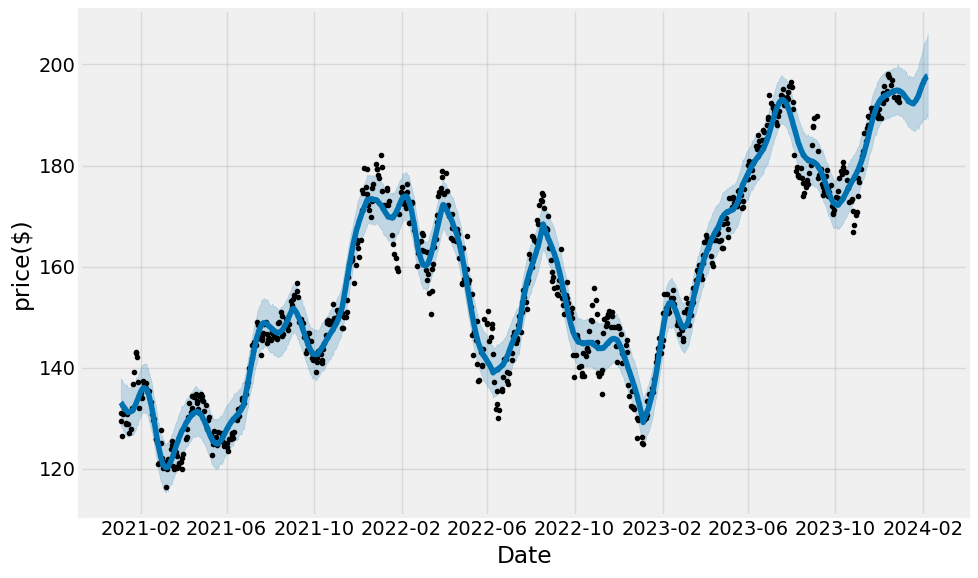

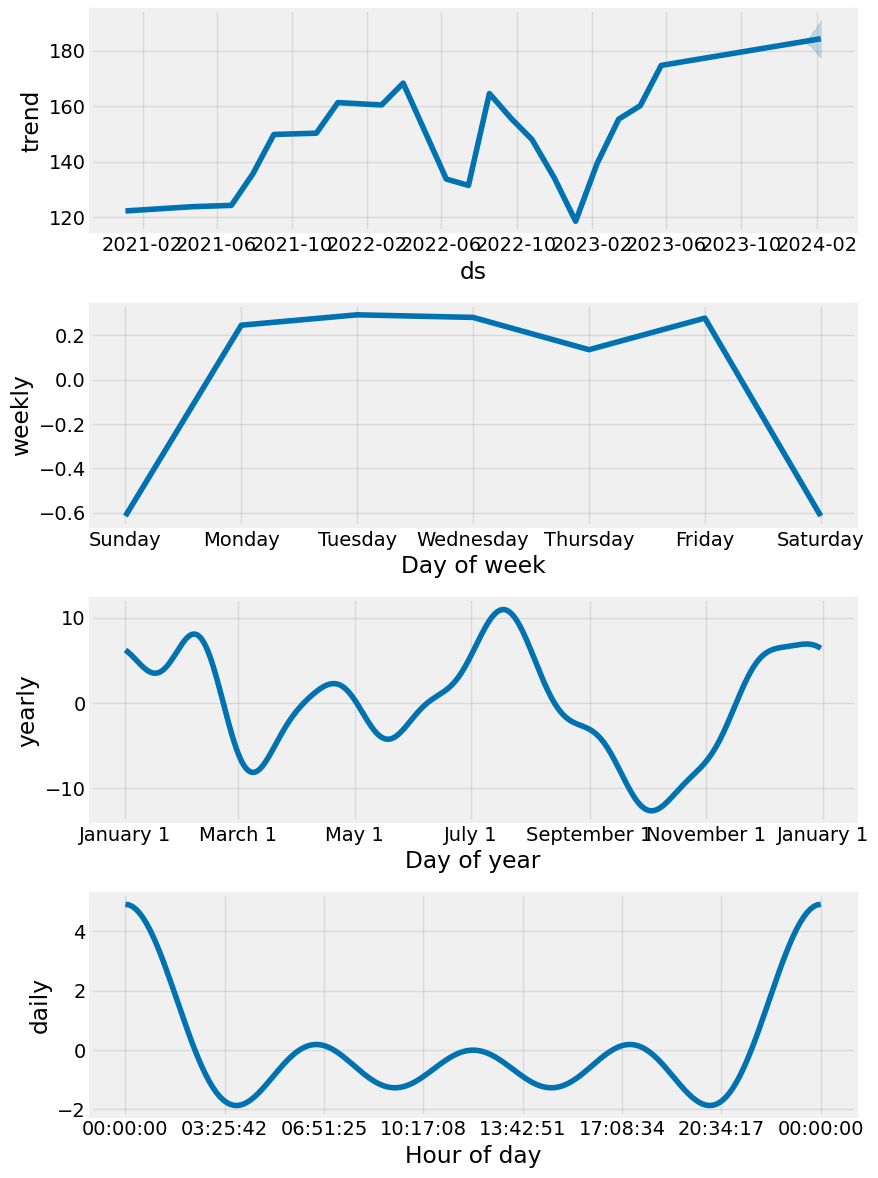

In [15]:
model_prophet2.plot(df_forecast2, xlabel = 'Date',ylabel ='price($)')
model_prophet2.plot_components(df_forecast2);

In [16]:
df_forecast2.set_index('ds', inplace=True)
test_data2 = df_recent['y']
fc2 = df_forecast2[df_forecast2.index>='2024-01-01'].iloc[:len(test_data2)]['yhat']

In [17]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

mse2 = mean_squared_error(test_data2, fc2)
print('MSE: ', mse2)
mae2 = mean_absolute_error(test_data2, fc2)
print('MAE: ', mae2)
rmse2 = math.sqrt(mean_squared_error(test_data2, fc2))
print('RMSE: ', rmse2)
mape2 = mean_absolute_percentage_error(test_data2, fc2)
print('MAPE: ' , '{:.2f}%'.format(mape2*100))
r2score2 = r2_score(test_data2,fc2)
print('r2 score: ', r2score2)

MSE:  50.89475047300344
MAE:  6.016919375808587
RMSE:  7.134055681938811
MAPE:  3.25%
r2 score:  -1.6031747737017783


In [18]:
us_holidays = make_holidays_df(
    year_list=[2021 + i for i in range(4)], country='US'
)
# us_holidays

In [19]:
model_prophet3 = Prophet(changepoint_prior_scale = 0.15, daily_seasonality = True, holidays=us_holidays)
model_prophet3.fit(df_input)

08:24:47 - cmdstanpy - INFO - Chain [1] start processing
08:24:48 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future3 = model_prophet3.make_future_dataframe(periods = fcast_time, freq = freq_option)

In [21]:
future3[~future3['ds'].isin(us_holidays['ds'])].iloc[890:900]

,ds


In [22]:
future3 = future3[future3['ds'].dt.dayofweek < 5] # 주말 제외 작업
future3 = future3[~future3['ds'].isin(us_holidays['ds'])] # 공휴일 제외 작업
df_forecast3 = model_prophet3.predict(future3)
df_forecast3[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
766,2024-02-01,198.395469,191.864352,204.731134
767,2024-02-02,198.842791,191.965483,205.585452
768,2024-02-05,199.828424,193.372199,207.341689
769,2024-02-06,199.993472,193.089649,207.195757
770,2024-02-07,200.106359,192.824522,207.040625


MSE:  54.36535284011533
MAE:  6.294536501431118
RMSE:  7.3732864341564355
MAPE:  3.40%
r2 score:  -1.7806898307096248


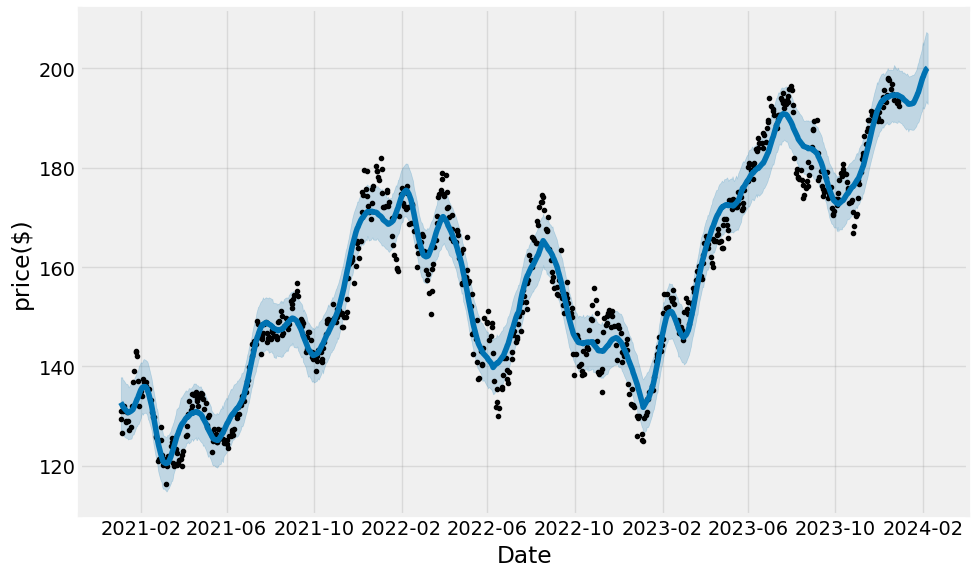

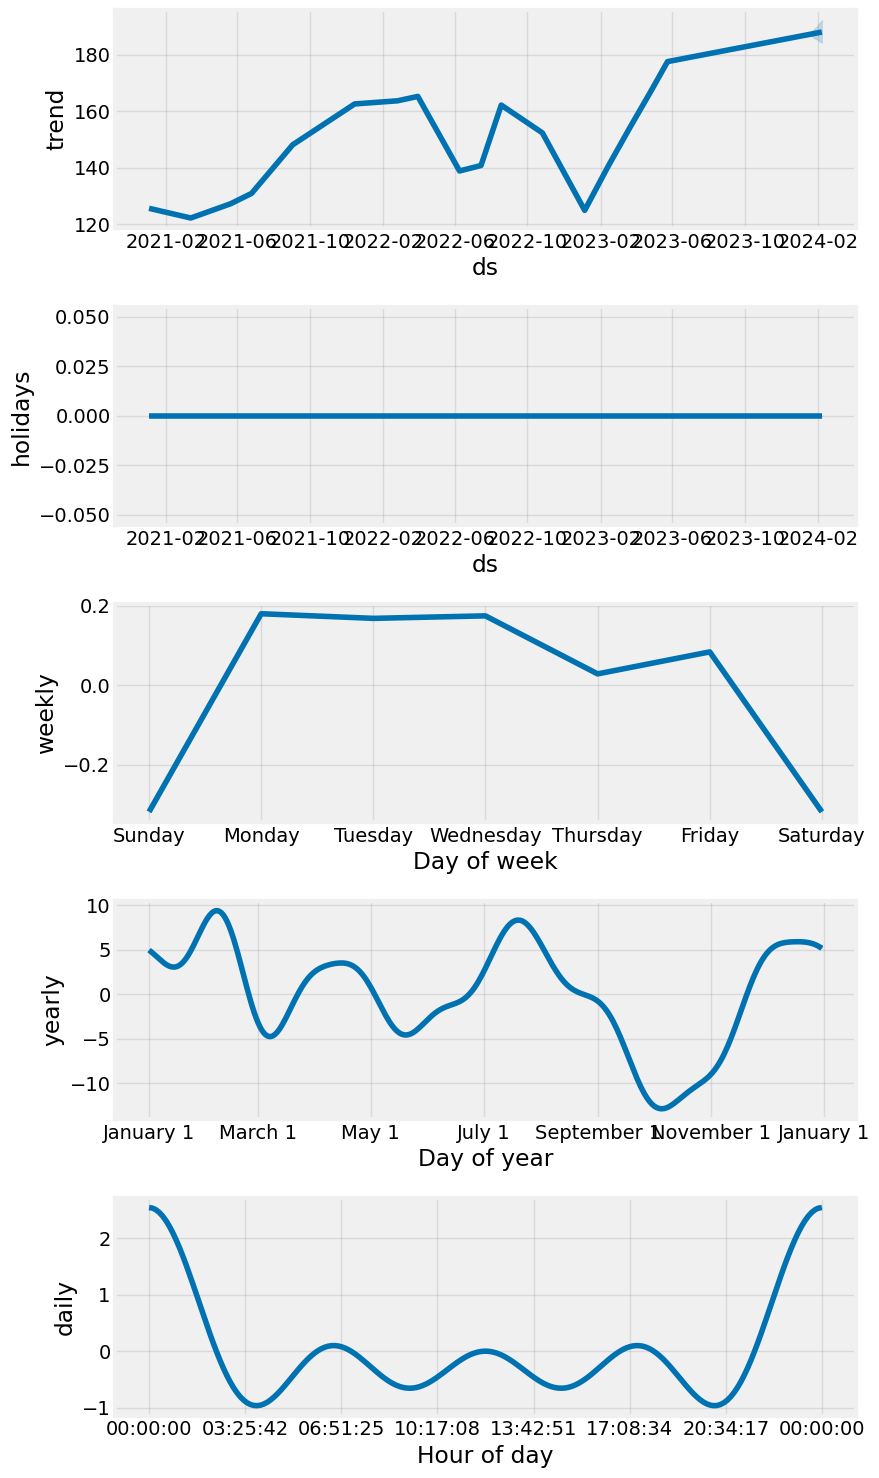

In [23]:
model_prophet3.plot(df_forecast3, xlabel = 'Date',ylabel ='price($)')
model_prophet3.plot_components(df_forecast3)
df_forecast3.set_index('ds', inplace=True)
test_data3 = df_recent['y']
fc3 = df_forecast3[df_forecast3.index>='2024-01-01'].iloc[:len(test_data3)]['yhat']

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

mse3 = mean_squared_error(test_data3, fc3)
print('MSE: ', mse3)
mae3 = mean_absolute_error(test_data3, fc3)
print('MAE: ', mae3)
rmse3 = math.sqrt(mean_squared_error(test_data3, fc3))
print('RMSE: ', rmse3)
mape3 = mean_absolute_percentage_error(test_data3, fc3)
print('MAPE: ' , '{:.2f}%'.format(mape3*100))
r2score3 = r2_score(test_data3,fc3)
print('r2 score: ', r2score3)

In [24]:
future.info()

<class 'pandas.core.frame.DataFrame'>
Index: 772 entries, 0 to 792
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      772 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 12.1 KB


08:24:49 - cmdstanpy - INFO - Chain [1] start processing
08:24:49 - cmdstanpy - INFO - Chain [1] done processing


MSE:  60.425383511949555
MAE:  6.634169622202473
RMSE:  7.773376583695759
MAPE:  3.58%
r2 score:  -2.090649479321042


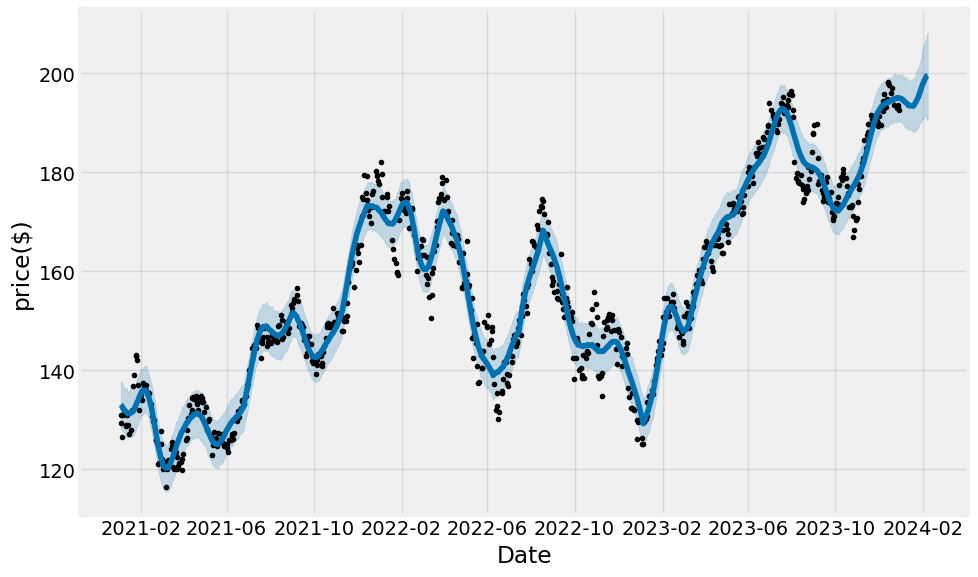

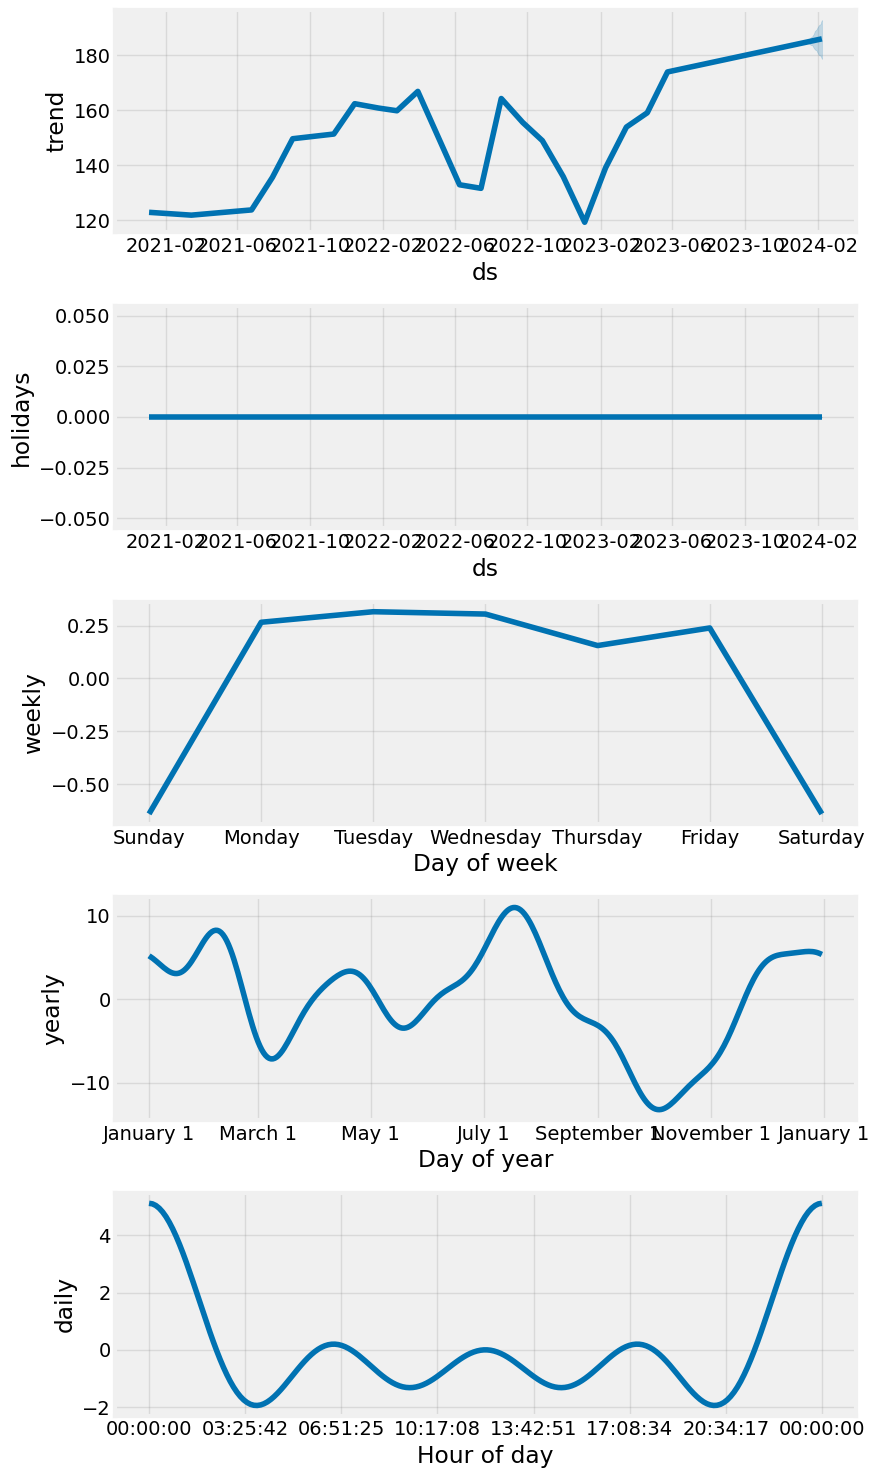

In [25]:
model_prophet4 = Prophet(changepoint_prior_scale = 0.3, daily_seasonality = True, holidays=us_holidays)
model_prophet4.fit(df_input)
future4 = model_prophet4.make_future_dataframe(periods = fcast_time, freq = freq_option)
future4 = future4[future4['ds'].dt.dayofweek < 5] # 주말 제외 작업
future4 = future4[~future4['ds'].isin(us_holidays['ds'])] # 공휴일 제외 작업
df_forecast4 = model_prophet4.predict(future4)
df_forecast4[['ds','yhat','yhat_lower','yhat_upper']].tail()
model_prophet4.plot(df_forecast4, xlabel = 'Date',ylabel ='price($)')
model_prophet4.plot_components(df_forecast4)
df_forecast4.set_index('ds', inplace=True)
test_data4 = df_recent['y']
fc4 = df_forecast4[df_forecast4.index>='2024-01-01'].iloc[:len(test_data4)]['yhat']

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

mse4 = mean_squared_error(test_data4, fc4)
print('MSE: ', mse4)
mae4 = mean_absolute_error(test_data4, fc4)
print('MAE: ', mae4)
rmse4 = math.sqrt(mean_squared_error(test_data4, fc4))
print('RMSE: ', rmse4)
mape4 = mean_absolute_percentage_error(test_data4, fc4)
print('MAPE: ' , '{:.2f}%'.format(mape4*100))
r2score4 = r2_score(test_data4,fc4)
print('r2 score: ', r2score4)

In [26]:
df.head(1)

,Open,High,Low,Close,Adj_Close,Volume,ds,y
Date,,,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.00209,143301900,2021-01-04,129.410004


In [27]:
# 이전 행의 값과 비교하는 함수 정의
def compare(data):
    if pd.isnull(data['prev_close']):
        return 'N/A'  # 첫 행은 이전 행이 없으므로 'N/A' 반환
    elif data['Close'] > data['prev_close']:
        return 'up'
    elif data['Close'] < data['prev_close']:
        return 'down'
    else:
        return 'same'

# 이전 행의 값을 저장하는 'prev_close' 열 추가
df_recent['prev_close'] = df_recent['Close'].shift(1)

# 비교 결과를 저장하는 'compare' 열 추가
df_recent['compare'] = df_recent.apply(compare, axis=1)

In [28]:
# df_recent[df_recent['compare']=='N/A']
df_recent.head(5)

,Open,High,Low,Close,Adj Close,Volume,ds,y,prev_close,compare
Date,,,,,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.403412,82488700,2024-01-02,185.639999,NaN,N/A
2024-01-03,184.220001,185.880005,183.429993,184.250000,184.015198,58414500,2024-01-03,184.250000,185.639999,down
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.678177,71983600,2024-01-04,181.910004,184.250000,down
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.949097,62303300,2024-01-05,181.179993,181.910004,down
2024-01-08,182.089996,185.600006,181.500000,185.559998,185.323517,59144500,2024-01-08,185.559998,181.179993,up


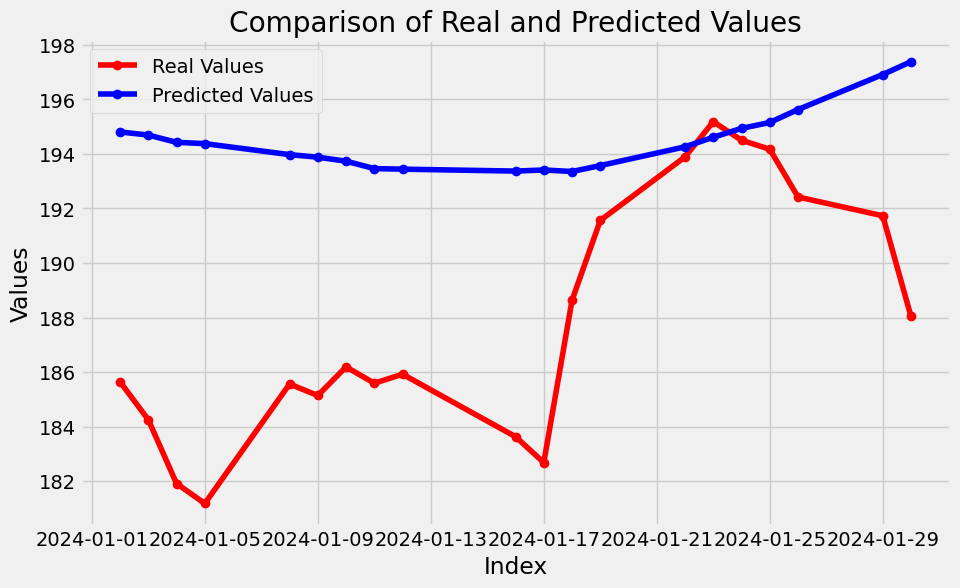

In [29]:
plt.figure(figsize=(10, 6))
df_forecast4_cut = df_forecast4[df_forecast4.index>='2024-01-01'].iloc[:len(test_data4)]
# x축을 Index로 지정하고, y축을 특정 컬럼 값으로 지정합니다.
plt.plot(df_recent.index, df_recent['Close'], 'ro-', label='Real Values')
plt.plot(df_forecast4_cut.index, df_forecast4_cut['yhat'], 'bo-', label='Predicted Values')

plt.title('Comparison of Real and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()

plt.show()

08:24:51 - cmdstanpy - INFO - Chain [1] start processing
08:24:51 - cmdstanpy - INFO - Chain [1] done processing


MSE:  125.83868208061749
MAE:  9.714456518833105
RMSE:  11.217784187646751
MAPE:  5.13%
r2 score:  -5.4364218255063985


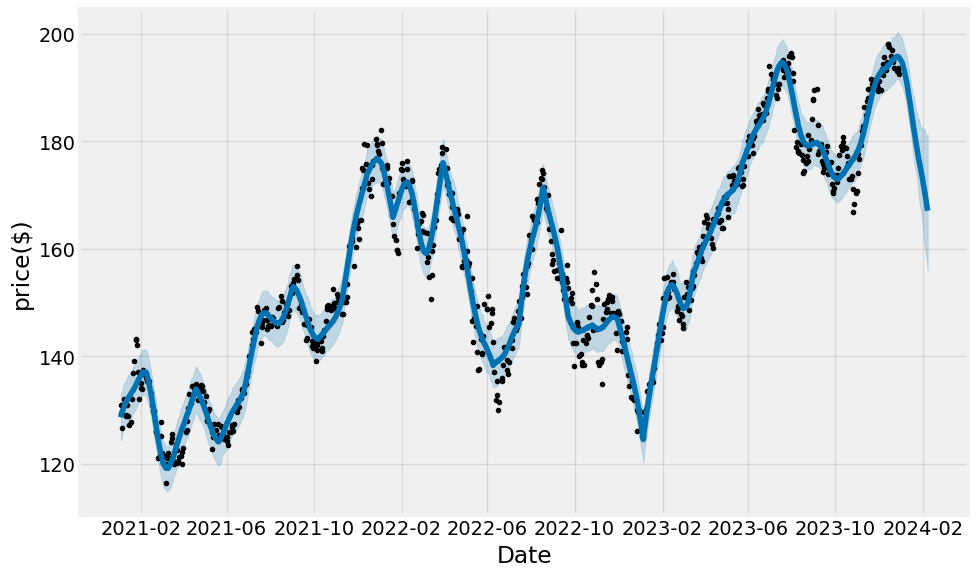

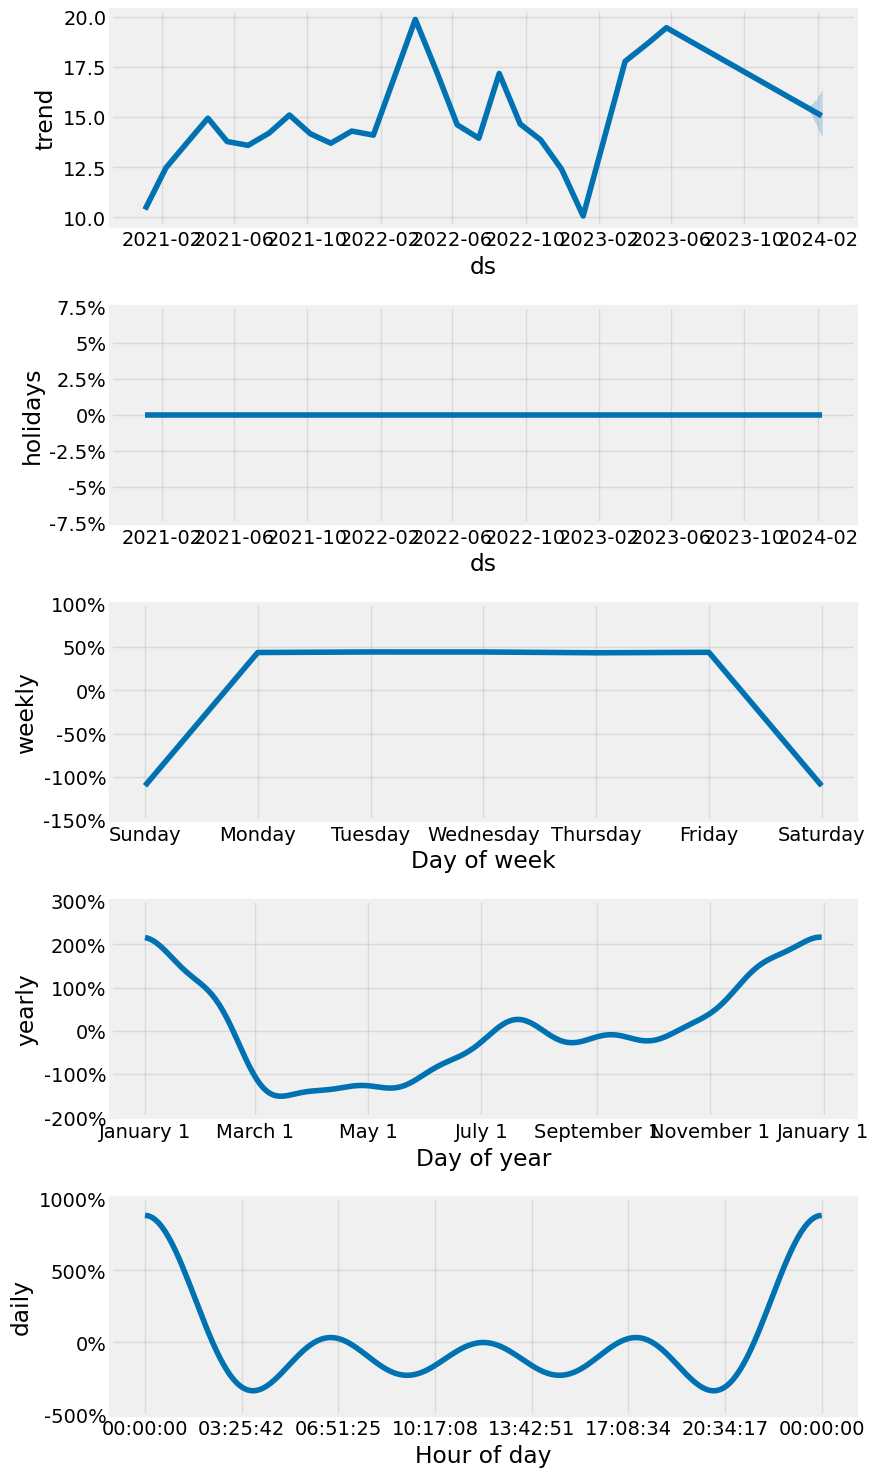

In [30]:
model_prophet5 = Prophet(changepoint_prior_scale = 0.15, daily_seasonality = True, holidays=us_holidays,seasonality_mode='multiplicative')
model_prophet5.fit(df_input)
future5 = model_prophet5.make_future_dataframe(periods = fcast_time, freq = freq_option)
future5 = future5[future5['ds'].dt.dayofweek < 5] # 주말 제외 작업
future5 = future5[~future5['ds'].isin(us_holidays['ds'])] # 공휴일 제외 작업
df_forecast5 = model_prophet5.predict(future4)
df_forecast5[['ds','yhat','yhat_lower','yhat_upper']].tail()
model_prophet5.plot(df_forecast5, xlabel = 'Date',ylabel ='price($)')
model_prophet5.plot_components(df_forecast5)
df_forecast5.set_index('ds', inplace=True)
test_data5 = df_recent['y']
fc5 = df_forecast5[df_forecast5.index>='2024-01-01'].iloc[:len(test_data5)]['yhat']

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

mse5 = mean_squared_error(test_data5, fc5)
print('MSE: ', mse5)
mae5 = mean_absolute_error(test_data5, fc5)
print('MAE: ', mae5)
rmse5 = math.sqrt(mean_squared_error(test_data5, fc5))
print('RMSE: ', rmse5)
mape5 = mean_absolute_percentage_error(test_data5, fc5)
print('MAPE: ' , '{:.2f}%'.format(mape5*100))
r2score5 = r2_score(test_data5,fc5)
print('r2 score: ', r2score5)

In [31]:
import pandas as pd
import yfinance as yf
start = '2021-01-01'
end = '2024-03-05'
symbol = 'AAPL' # "005930.KS"
total_df = yf.download(symbol, start, end)
total_df = total_df.rename(columns={'Adj Close': 'Adj_Close'})
total_df['ds'] = pd.to_datetime(total_df.index, format = '%Y-%m-%d') # 굳이 넣어야하나 고민중
total_df['y'] = total_df['Close'] # 마찬가지로 굳이 넣어야하나 고민중
total_df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj_Close,Volume,ds,y
Date,,,,,,,,
2021-01-04,133.520004,133.610001,126.760002,129.410004,127.002129,143301900,2021-01-04,129.410004
2021-01-05,128.889999,131.740005,128.429993,131.009995,128.572342,97664900,2021-01-05,131.009995
2021-01-06,127.720001,131.050003,126.379997,126.599998,124.244377,155088000,2021-01-06,126.599998


In [1]:
import pandas as pd
import yfinance as yf
start = '2017-01-01'
end = '2023-12-31'
symbol = 'AAPL' # "005930.KS"
total_train_df = yf.download(symbol, start, end)
total_train_df = total_train_df.rename(columns={'Adj Close': 'Adj_Close'})
total_train_df['ds'] = pd.to_datetime(total_train_df.index, format = '%Y-%m-%d') # 굳이 넣어야하나 고민중
total_train_df['y'] = total_train_df['Close'] # 마찬가지로 굳이 넣어야하나 고민중
total_train_df.head(3)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj_Close,Volume,ds,y
Date,,,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,26.989269,115127600,2017-01-03,29.037500
2017-01-04,28.962500,29.127501,28.937500,29.004999,26.959055,84472400,2017-01-04,29.004999
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.096155,88774400,2017-01-05,29.152500


In [2]:
total_train_df_input = total_train_df[['ds','y']]

In [3]:
from prophet.make_holidays import make_holidays_df
us_holidays = make_holidays_df(
    year_list=[2017 + i for i in range(8)], country='US'
)

In [37]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

# 데이터를 8:2 비율로 나누기
train_size = int(len(total_train_df_input) * 0.8)
df_train = total_train_df_input[:train_size]
df_test = total_train_df_input[train_size:]

# 하이퍼파라미터 그리드 생성
param_grid = {
    'changepoint_prior_scale': [0.7, 0.3, 0.15, 0.05],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'n_changepoints': [10, 25, 50],
    'seasonality_mode': ['additive', 'multiplicative'],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# 모든 하이퍼파라미터 조합에 대해 모델 생성 및 평가
all_params = ParameterGrid(param_grid)
mse_scores = []
best_score = np.inf
best_params = None

for params in tqdm(all_params):
    # print("현재 파라미터:", params)
    model = Prophet(daily_seasonality=True, holidays=us_holidays, **params).fit(df_train)
    forecast_test = model.predict(df_test)
    mse = mean_squared_error(df_test['y'], forecast_test['yhat'])
    mse_scores.append(mse)
    # print('mse값은 ', mse)

    if mse < best_score:
        best_score = mse
        best_params = params
        print(best_score, params)

print('Best params:', best_params, 'mse: ',best_score)

  0%|          | 0/384 [00:00<?, ?it/s]08:32:53 - cmdstanpy - INFO - Chain [1] start processing
08:32:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/384 [00:00<01:56,  3.29it/s]08:32:53 - cmdstanpy - INFO - Chain [1] start processing


8.878774442495683 {'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


08:32:54 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/384 [00:00<02:25,  2.62it/s]08:32:54 - cmdstanpy - INFO - Chain [1] start processing
08:32:54 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 3/384 [00:01<02:16,  2.80it/s]08:32:54 - cmdstanpy - INFO - Chain [1] start processing
08:32:54 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/384 [00:01<02:20,  2.71it/s]08:32:54 - cmdstanpy - INFO - Chain [1] start processing
08:32:55 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 5/384 [00:01<02:13,  2.84it/s]08:32:55 - cmdstanpy - INFO - Chain [1] start processing


8.602067239719455 {'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.01, 'n_changepoints': 10, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


08:32:55 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 6/384 [00:02<02:13,  2.83it/s]08:32:55 - cmdstanpy - INFO - Chain [1] start processing
08:32:55 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 7/384 [00:02<02:24,  2.61it/s]08:32:56 - cmdstanpy - INFO - Chain [1] start processing
08:32:56 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 8/384 [00:03<02:33,  2.45it/s]08:32:56 - cmdstanpy - INFO - Chain [1] start processing
08:32:57 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 9/384 [00:03<03:12,  1.95it/s]08:32:57 - cmdstanpy - INFO - Chain [1] start processing


5.48703605708983 {'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.01, 'n_changepoints': 25, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


08:32:57 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 10/384 [00:04<03:25,  1.82it/s]08:32:57 - cmdstanpy - INFO - Chain [1] start processing
08:32:58 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 11/384 [00:05<03:30,  1.77it/s]08:32:58 - cmdstanpy - INFO - Chain [1] start processing
08:32:58 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 12/384 [00:05<03:39,  1.70it/s]08:32:59 - cmdstanpy - INFO - Chain [1] start processing
08:32:59 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 13/384 [00:06<03:59,  1.55it/s]08:32:59 - cmdstanpy - INFO - Chain [1] start processing
08:33:00 - cmdstanpy - INFO - Chain [1] done processing
  4%|▎         | 14/384 [00:07<04:07,  1.50it/s]08:33:00 - cmdstanpy - INFO - Chain [1] start processing
08:33:00 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 15/384 [00:07<03:45,  1.63it/s]08:33:01 - cmdstanpy - INFO - Chain [1] start processing
08:33:01 - cmdstanpy - INFO - Chai

4.942868912482838 {'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.01, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


08:33:07 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 22/384 [00:14<06:03,  1.00s/it]08:33:08 - cmdstanpy - INFO - Chain [1] start processing


4.595530173876971 {'changepoint_prior_scale': 0.7, 'holidays_prior_scale': 0.01, 'n_changepoints': 50, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}


08:33:08 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 23/384 [00:15<06:14,  1.04s/it]08:33:09 - cmdstanpy - INFO - Chain [1] start processing
08:33:10 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 24/384 [00:16<06:20,  1.06s/it]08:33:10 - cmdstanpy - INFO - Chain [1] start processing
08:33:10 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 25/384 [00:17<05:04,  1.18it/s]08:33:10 - cmdstanpy - INFO - Chain [1] start processing
08:33:10 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 26/384 [00:17<04:15,  1.40it/s]08:33:11 - cmdstanpy - INFO - Chain [1] start processing
08:33:11 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 27/384 [00:18<03:41,  1.61it/s]08:33:11 - cmdstanpy - INFO - Chain [1] start processing
08:33:11 - cmdstanpy - INFO - Chain [1] done processing
  7%|▋         | 28/384 [00:18<03:18,  1.79it/s]08:33:11 - cmdstanpy - INFO - Chain [1] start processing
08:33:12 - cmdstanpy - INFO - Chai

3.9760788294024842 {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


08:35:10 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▎    | 206/384 [02:17<01:27,  2.04it/s]08:35:10 - cmdstanpy - INFO - Chain [1] start processing
08:35:11 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▍    | 207/384 [02:17<01:46,  1.66it/s]08:35:11 - cmdstanpy - INFO - Chain [1] start processing
08:35:12 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▍    | 208/384 [02:18<02:01,  1.44it/s]08:35:12 - cmdstanpy - INFO - Chain [1] start processing
08:35:12 - cmdstanpy - INFO - Chain [1] done processing
 54%|█████▍    | 209/384 [02:19<02:03,  1.42it/s]08:35:13 - cmdstanpy - INFO - Chain [1] start processing
08:35:13 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▍    | 210/384 [02:20<02:04,  1.40it/s]08:35:13 - cmdstanpy - INFO - Chain [1] start processing
08:35:14 - cmdstanpy - INFO - Chain [1] done processing
 55%|█████▍    | 211/384 [02:21<02:09,  1.33it/s]08:35:14 - cmdstanpy - INFO - Chain [1] start processing
08:35:15 - cmdstanpy - INFO 

Best params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'n_changepoints': 25, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} mse:  3.9760788294024842


In [35]:
print(best_score)

4.595530173876971


In [12]:
start_r = '2024-01-01'
end_r = '2024-01-10'
ticker_r = 'AAPL'

df_recent = yf.download(ticker_r, start=start_r, end=end_r)
df_recent['ds'] = pd.to_datetime(df_recent.index, format = '%Y-%m-%d')
df_recent['y'] = df_recent['Close']
# display(df_recent.head(3))

[*********************100%%**********************]  1 of 1 completed


09:52:03 - cmdstanpy - INFO - Chain [1] start processing
09:52:04 - cmdstanpy - INFO - Chain [1] done processing


MSE:  7.223671358697563
MAE:  2.3591340160553833
RMSE:  2.687688850796826
MAPE:  1.28%
r2 score:  -1.3068077344919895


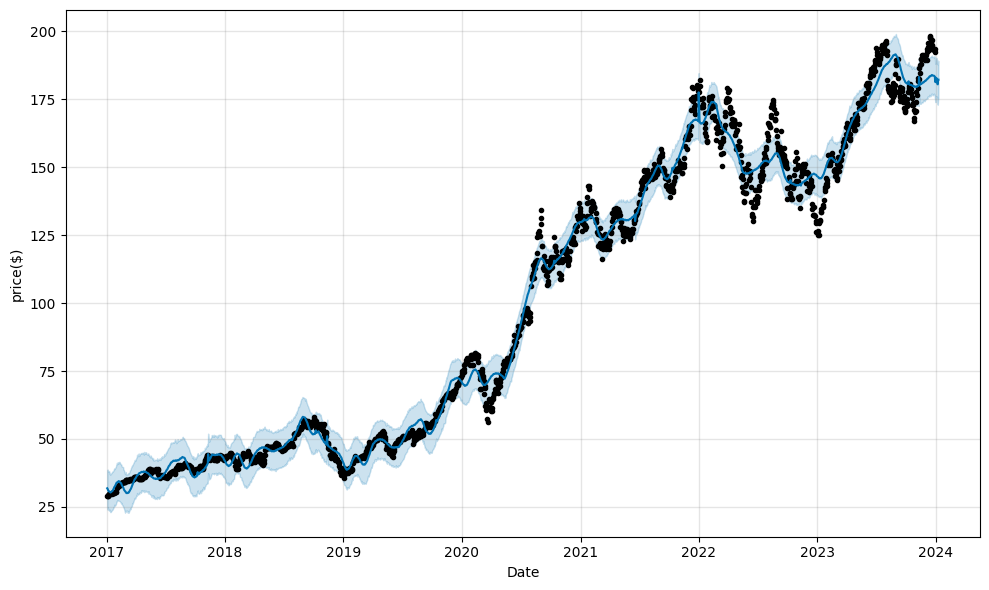

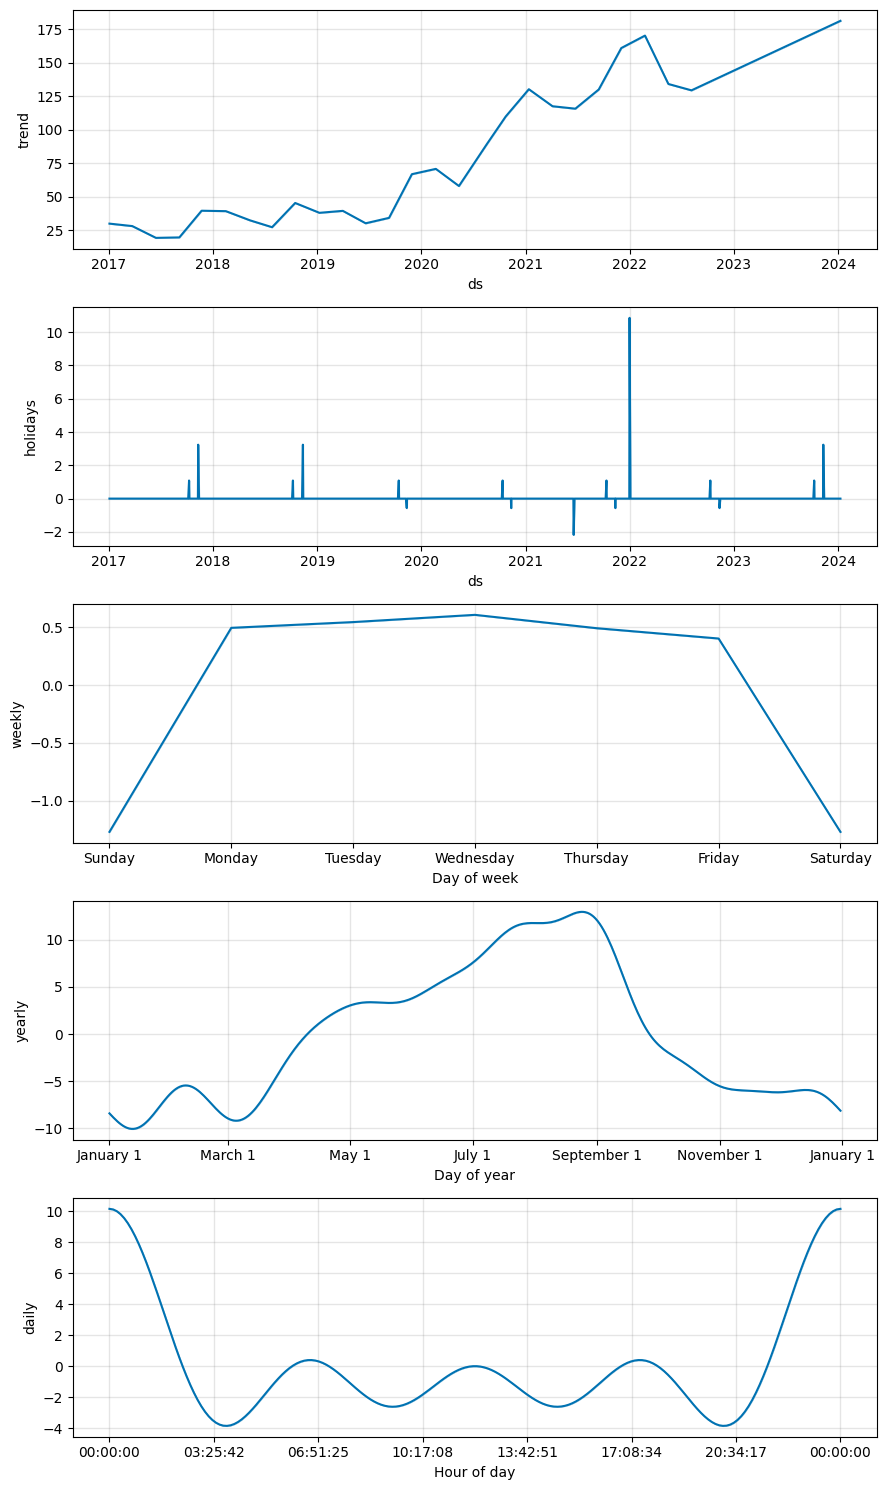

In [23]:
from prophet import Prophet
model_prophet6 = Prophet(changepoint_prior_scale=0.1, daily_seasonality = True, holidays=us_holidays, holidays_prior_scale=0.02, 
                         n_changepoints=73, seasonality_mode='multiplicative', seasonality_prior_scale=0.13)
model_prophet6.fit(total_train_df_input)

fcast_time = 11 #365 # 365일 예측
freq_option = 'D'

future6 = model_prophet6.make_future_dataframe(periods = fcast_time, freq = freq_option)
future6 = future6[future6['ds'].dt.dayofweek < 5] # 주말 제외 작업
future6 = future6[~future6['ds'].isin(us_holidays['ds'])] # 공휴일 제외 작업
df_forecast6 = model_prophet6.predict(future4)
df_forecast6[['ds','yhat','yhat_lower','yhat_upper']].tail()
model_prophet6.plot(df_forecast6, xlabel = 'Date',ylabel ='price($)')
model_prophet6.plot_components(df_forecast6)
df_forecast6.set_index('ds', inplace=True)
test_data6 = df_recent['y']
fc6 = df_forecast6[df_forecast6.index>='2024-01-01'].iloc[:len(test_data6)]['yhat']

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

mse6 = mean_squared_error(test_data6, fc6)
print('MSE: ', mse6)
mae6 = mean_absolute_error(test_data6, fc6)
print('MAE: ', mae6)
rmse6 = math.sqrt(mean_squared_error(test_data6, fc6))
print('RMSE: ', rmse6)
mape6 = mean_absolute_percentage_error(test_data6, fc6)
print('MAPE: ' , '{:.2f}%'.format(mape6*100))
r2score6 = r2_score(test_data6,fc6)
print('r2 score: ', r2score6)